## Models from Scratch: Linear Discriminant Analysis

##### Implementing the fundamental functions used to fit a linear discriminant analysis model (Bayesian approach). 
***

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('./data/College.csv', index_col=0)
private = df[df['Private']=='Yes']  # All data for private unis
public = df[df['Private']=='No']  # All data for public unis

df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


We're going to build an LDA model to classify whether or not a university is private or public. Unlike logistic regression, LDA works fine for multiply classes, but in this example we'll stick to two. First, let's ensure that the data appear seperable. We'll do this by simple visualizations:

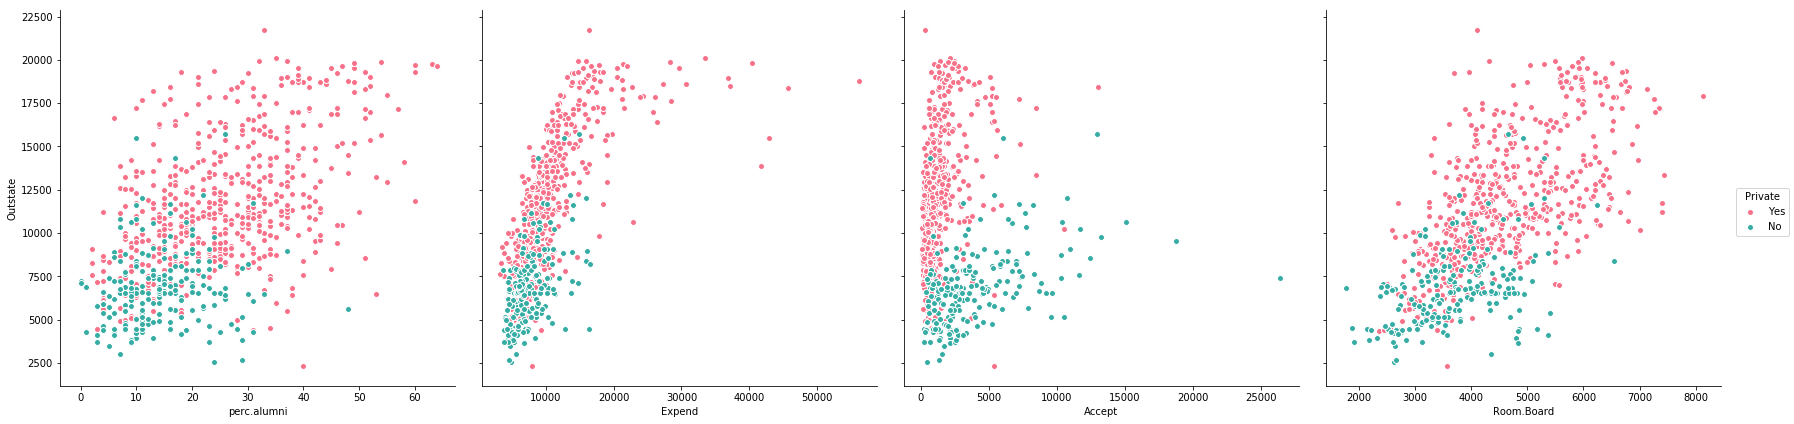

In [4]:
sns.pairplot(x_vars=["perc.alumni", 'Expend', 'Accept', 'Room.Board'], y_vars=['Outstate'], data=df, hue="Private", size=6, palette="husl")

The data show reasonably good seperation, at least in respect to the 'Outstate' predictor, which is the out-of-state tuition at that university. 

Generally, LDA (and QDA) assume that the conditional distribution of X given Y is normal. So in this case, we assume P(tuition | y ∈ k) ~ Normal, where k={private, public}. While this will rarely be 100% true, the following plot shows that the assumption isn't too badly violated: 

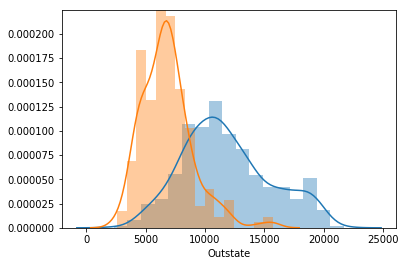

In [5]:
sns.distplot(private['Outstate'])
sns.distplot(public['Outstate'])

### Fitting The Model: First Approach 
#### For this first approach, we'll use only a single predictor (out-of-state tuition), since this seems to be the most significant.

In [6]:
private_mean = np.mean(private['Outstate'])
public_mean = np.mean(public['Outstate'])

# Estimated prior probabilities (we won't use these because they're not at all representative of the population)
private_prior = len(private) / len(df)
public_prior = len(public) / len(df)

In [7]:
def pooled_variance(x1, x2):
    """Returns the pooled variance for 2 vectors of data"""
    tss1 = 0  # total sum of squares for first vector
    for n in x1:
        tss1 += (n - private_mean)**2
        
    tss2 = 0   # total sum of squares for second vector
    for n in x2:
        tss2 += (n - public_mean)**2
    
    return (tss1 + tss2) / (len(x1) - 2)
        
# Assume variance doesnt depend on class; pool variances together (This leads to the linear discriminant function)
variance = pooled_variance(private['Outstate'], public['Outstate'])

In [8]:
def discriminant_1d(x):
    """Returns the pair of discriminant scores when there are 2 classes and 1 predictor"""
    class_1 = (x*(private_mean/variance)) - ((private_mean**2)/(2*variance))
    class_2 = (x*(public_mean/variance)) - ((public_mean**2)/(2*variance))
    return (class_1, class_2)

def classify(x):
    """Classifies an observation x by assigning it to the class that has a greater discriminant score."""
    score = discriminant_1d(x)
    if score[0] > score[1]: 
        return "Yes" # Private school
    else: 
        return "No"  # Public school

In [9]:
def training_error():
    """Returns the training error for this LDA classifier."""
    incorrect = 0
    for i, x in enumerate(df['Outstate']):
        if classify(x) != df['Private'][i]:
            incorrect += 1
    
    return incorrect / len(df)

In [10]:
training_error()

0.22393822393822393

So we've classified approximately 78% of the training observations correctly using just a single predictor.
However, this is the training error--not the test error--so it tells us very little about how this model would preform on new data. Also, 72% of the observations in the dataset correspond to private universities. Thus, the model is only a 6% improvement on simply classifying every observation to private.

### Fitting The Model: Second Approach 
#### Now we allow for multiple predictors

In [11]:
# New dataframe with the variables used in this example. 
df2 = df[["Private", "Outstate", "perc.alumni", "Room.Board"]].copy()
predictors = ["Outstate", "perc.alumni", "Room.Board"]

In [12]:
private_mean_vector = np.array([np.mean(private['Outstate']), np.mean(private['perc.alumni']), np.mean(private['Room.Board'])])
public_mean_vector = np.array([np.mean(public['Outstate']), np.mean(public['perc.alumni']), np.mean(public['Room.Board'])]) 

In [13]:
# Assume variance doesnt depend on class. (This leads to the linear discriminant function)
cov = np.cov([df[p] for p in predictors])
cov_inv = np.linalg.inv(cov)

In [14]:
def discriminant(x):
    """Returns the pair of discriminant scores when there are 2 classes and 3 predictors"""
    a = np.dot(np.dot(np.transpose(x), cov_inv), private_mean_vector)
    b = np.dot(np.dot((1/2)*np.transpose(private_mean_vector), cov_inv), private_mean_vector)
    class1 = a - b
    
    a = np.dot(np.dot(np.transpose(x), cov_inv), public_mean_vector)
    b = np.dot(np.dot((1/2)*np.transpose(public_mean_vector), cov_inv), public_mean_vector)
    class2 = a - b
    return (class1, class2)

In [15]:
def classify(x):
    """Classifies an observation x by assigning it to the class that has a greater discriminant score."""
    score = discriminant(x)
    if score[0] > score[1]: 
        return "Yes" # Private school
    else: 
        return "No"  # Public school

In [16]:
def training_error():
    """Returns the training error for this LDA classifier."""
    incorrect = 0
    for index, row in df2.iterrows():
        x = [row['Outstate'], row['perc.alumni'], row['Room.Board']]
        if classify(x) != row['Private']:
            incorrect += 1
    
    return incorrect / len(df)

In [17]:
training_error()

0.20077220077220076

### Basic Linear Discriminant Analysis Class

In [46]:
from collections import Counter

# Unfinished
class LDA():
    
    def __init__(self, X, y_name):
        """
        Initalizes an LDA object
        
        Parameters: 
            X: A Dataframe object of only the relevant predictors and response.
            y_name: A string that corresponds to the name of the response variable
            
        """
        self.X = X
        self.y_name = y_name
        self.y = self.X[y_name]
        self.n = len(X)
        self.p = len(list(X))
        self.predictors = list(X)
        self.predictors.remove(y_name)
        self.num_classes = len(Counter(self.y))
        self.classes = list(Counter(self.y).keys())
        
    def discriminant(self, x):
        """Returns the set of discriminant scores for a feature vector x"""
        cov = np.cov([self.X[p] for p in self.predictors])
        cov_inv = np.linalg.inv(cov)
        
        scores = []
        # Calculate discriminant score of x in each class
        for cls in self.classes:
            mean_vector = self.get_mean_vector(cls)
            a = np.dot(np.dot(np.transpose(x), cov_inv), mean_vector)
            b = np.dot(np.dot((1/2)*np.transpose(mean_vector), cov_inv), mean_vector)
            scores.append(a - b)
            
        return scores
    
    def classify(self, x):
        """Classifies an observation x by assigning it to the class that has a greater discriminant score."""
        # Not yet implemented
        pass

    def get_mean_vector(self, cls):
        """ Returns the mean_vector of all predictors given a class value 'cls' """
        mean_vector = []
        
        # Dataframe corresponding only to values of this class
        data  = self.X[self.X[self.y_name] == cls]
        
        # For each predictor, calculate its mean in the provided class
        for p in self.predictors:
            mean_vector.append(np.mean(data[p]))
            
        return np.array(mean_vector)
            
            

In [47]:
X = df[["Private", "Outstate", "perc.alumni", "Room.Board"]].copy()
model = LDA(X, 'Private')